# 0. Initialize

In [1]:
import gym
import random
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import namedtuple, deque

# 1. Environment Description
The environment consists of single pendulum that can swing 360 degrees. The pendulum is actuated by applying a torque on its pivot point. The goal is to __swing it up so it stays upright__ and maintain it as long as possible. The pendulum can move freely, subject only to gravity and the action applied by the agent.


<img src="attachment:image.png" width="400">

In [2]:
env_name = "Pendulum-v0"
env = gym.make(env_name)

[2021-05-30 22:58:53,884] Making new env: Pendulum-v0


### 1-1. State

Cartpole environment consists of 3-dimensional state, with following components:

| Num |      Observation      |     Min    |    Max    |
|:---:|:---------------------:|:----------:|:---------:|
|  0  |     cos($\theta$)     |    -1.0    |    1.0    |
|  1  |     sin($\theta$)     |    -1.0    |    1.0    |
|  2  |          $\dot{\theta}$   | -8.0 | 8.0 |


In [3]:
env.observation_space

Box(3,)

### 1-2. Action

The action is 1-dimensional continuous action, such as; 

| Num |         Action         | Min | Max |
|:---:|:----------------------:|:----------------------:|:----------------------:|
|  0  |  Joint effort |  -2.0 | 2.0|

In [13]:
env.action_space
print(env.action_space.low, env.action_space.high)

[-2.] [2.]


### 1-3. Rewards
The equation for reward is:
\begin{equation}
 r_t = -(\theta^2 + 0.1\cdot \theta_dt^2 + 0.001\cdot action^2) 
\end{equation}

$\theta$ is normalized between $\pi$ and $-\pi$. The lowest reward is $-(\pi^2 + 0.1*8^2 + 0.001*2^2) = -16.2736044$, and the highest reward is 0. Therefore, reward is maximized when $\theta=0$, and minimized when $\theta=\pi, -\pi$. 

# 2. Replay Memory

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory:
    def __init__(self, length):
        self.memory = deque(maxlen=length)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, size):
        sample = random.sample(self.memory, size)

        state = [i[0] for i in sample]
        action = [i[1] for i in sample]
        reward = [i[2] for i in sample]
        next_state = [i[3] for i in sample]
        terminal = [i[4] for i in sample]

        state = np.stack(state)
        state = torch.Tensor(state).squeeze()

        next_state = np.stack(next_state)
        next_state = torch.Tensor(next_state).squeeze()

        reward = np.array(reward)
        reward = torch.tensor(reward, dtype=torch.float32).reshape(-1, 1)

        terminal = np.array(terminal).astype(int)
        terminal = torch.tensor(terminal).reshape(-1, 1)

        action = np.array(action)
        action = torch.tensor(action, dtype=torch.float32)

        return state, action, reward, next_state, terminal

# 2. Actor/Critic Network


## 2-1. Actor Network
__Actor__ : outputs deterministic action given state, $a_t = \mu(s_t|\theta_{\mu})$.
- input : state
- output  : action

__Note__ : We use output activation of the actor network using $tanh$ function, to make $a_t\in [-a_{min},a_{max}]$.

### We use Tanh function as an activation function of actor; how tanh function looks like?

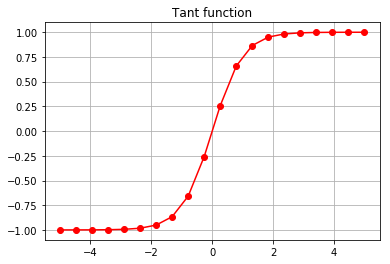

In [6]:
x = np.linspace(-5, 5, 20)
y = np.tanh(x)
plt.plot(x, y, color='red', marker="o")
plt.title("Tant function") 
plt.grid()
plt.show()

In [7]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=[64, 64]):
        super(Actor, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        input_dims = [state_dim] + hidden_dim
        output_dims = hidden_dim + [action_dim]

        for in_dim, out_dim in zip(input_dims, output_dims):
            self.layers.append(nn.Linear(in_dim, out_dim))

        for i in range(len(hidden_dim)):
            self.activations.append(nn.LeakyReLU())

        self.activations.append(nn.Tanh())

    def forward(self, state):
        x = state
        for l, activation in zip(self.layers, self.activations):
            x = l(x)
            x = activation(x)
        return x

## 2-2. Critic Network

__Critic__ : $Q(s_t,a_t|\theta_Q)$, evaluates state-action function
- input :  state, action
- output : state-action value

__Note__ : as the critic value has no upper/lower limit, we do not use final activation on critic network.

In [8]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64, output_dim=1):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(state_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim + action_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, state, action):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(torch.cat([x, action], dim=-1)))
        x = self.l3(x)

        return x

## 2-5 Ornstein–Uhlenbeck process

OU process is an stochastic process with temporal correlation. In the DDPG paper, authors use OU pross, as the most of the actions in the environment are time-correlated (the law of inertia)

__OU process__

 <div align="center"> $dx_t = \theta(\mu-x_t)dt + \sigma dW_t$ </div>

* $\mu$ is an constant
* $\theta$ determines how fast the process will converge to $\mu$
* $\sigma$ determines randomness of the process
* $W_t$ is an Einer process


__Build OU process__

In [9]:
class OUNoise:
    """
    Taken from https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
    """

    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=1000):
        self.mu = mu
        self.theta = theta
        self.sigma = max_sigma
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
        self.action_dim = action_space
        self.reset()

        self.epsilon = 1.0
        self.epsilon_decay = 0.00001
        self.epsilon_min = 0.05

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state() * self.epsilon

        self.epsilon -= self.epsilon_decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min

        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, -1.0, 1.0)

#### The OU process is correlated on time domain, such as; 

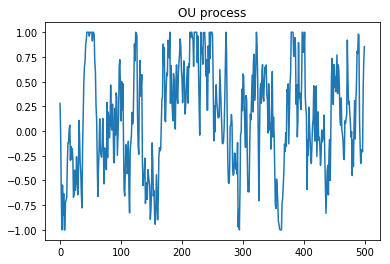

In [10]:
import matplotlib.pyplot as plt

sample_ou_noise = OUNoise(1)
sample_ou_noise.reset()

out = []
for _ in range(500):
    out.append(sample_ou_noise.get_action(0))
    
plt.plot(out)
plt.title('OU process')
plt.show()

# Task: Complete the `DDPGAgent()` class [90 pt]


* Task 1 [10pt]: Create your own replay memory of `maximum capacity = 1000`
* Task 2 [20pt]: Complete the `get_action()` function of the agent. 
* Task 3 [20pt]: Complete the critic loss calculation
* Task 4 [30pt]: Complete the actor loss calculation
* Task 5 [10pt]: Initialize the DDPGAgent on the training loop

In [89]:
class DDPGAgent(nn.Module):
    def __init__(self, state_dim, action_dim, action_min, action_max, gamma=0.99):
        super(DDPGAgent, self).__init__()
        self.action_min = np.array(action_min)
        self.action_max = np.array(action_max)

        self.gamma = gamma
        self.ou_noise = OUNoise(action_dim)

        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim, action_dim)

        self.actor_target = Actor(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-3)

        ################################################################
        # Task 1: Create a replay memory with maximum capacity=1000
        self.memory = ReplayMemory(1000)
        ################################################################
        self.batch_size = 50
        
        self.num_fit = 0

        self.loss_ftn = nn.MSELoss()

    def get_action(self, state, t=0):
        action_before_norm = self.actor(state).detach().numpy() # ranges in [-1, 1]
        action_before_norm = self.ou_noise.get_action(action_before_norm, t)# ranges in [-1, 1]
        
        ################################################################
        # Task 2: Complete the get_action() function of the agent.
        action = np.clip(action_before_norm * 2, self.action_min, self.action_max)
        # To make sure the action ranges in [action_min, action_max]
        ################################################################
        
        return action_before_norm, action

    def push(self, transition):
        self.memory.push(transition)

    def fit(self):
        if len(self.memory) < self.batch_size:
            return 0, 0
            
        state, action, reward, next_state, terminal = self.memory.sample(self.batch_size)

        q = self.critic(state, action)
        
        next_q_val = self.critic_target(next_state, self.actor_target(next_state))
        ################################################################
        # Task 3: Complete the critic loss calculation
        target_q = reward + self.gamma * next_q_val * (1 - terminal)
        
        # Critic loss
        critic_loss = self.loss_ftn(q.squeeze(), target_q.squeeze().detach())
        ################################################################

        # Update Critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        ################################################################
        # Task 4: Complete the actor loss calculation
        mu_s = torch.clamp(self.actor(state)*2, self.action_min[0], self.action_max[0])
        actor_loss = - self.critic(state, mu_s).mean()
#         actor_loss = - torch.sum(self.critic(state, action)) / self.batch_size
        ################################################################

        # Update Actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        if self.num_fit % 100 == 0:
            self.critic_target.load_state_dict(self.critic.state_dict())
            self.actor_target.load_state_dict(self.actor.state_dict())


        return critic_loss.item(), actor_loss.item()

### Full training code; you can check your agent using following training code.

In [90]:
# initialize environment / action
env_name = "Pendulum-v0"
env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

action_low = env.action_space.low
action_high = env.action_space.high

################################################################
# Task 5: Initialize the DDPGAgent on the training loop
agent = DDPGAgent(state_dim, action_dim, action_low, action_high)
################################################################

MAX_EPISODES = 500

# Performance metric
rewards = []
critic_loss_traj = []
actor_loss_traj = []

for e in range(MAX_EPISODES):

    state = env.reset()
    episode_reward = 0
    step = 0
    critic_loss_epi = []
    actor_loss_epi = []

    while True:

        state = torch.tensor(state, dtype=torch.float32)
        action_bef_norm, action = agent.get_action(state, step)

        next_state, reward, done, info = env.step(action)

        transition = [state, action_bef_norm, reward, next_state, done]
        
        agent.push(transition) # Saves transition on every step

        state = next_state
        episode_reward += reward

  
        critic_loss, actor_loss = agent.fit()

        critic_loss_epi.append(critic_loss)
        actor_loss_epi.append(actor_loss)
            
        if done:
            rewards.append(episode_reward)
            critic_loss_traj += critic_loss_epi
            actor_loss_traj += actor_loss_epi
            
            critic_mean = sum(critic_loss_epi) / len(critic_loss_epi)
            actor_mean = sum(actor_loss_epi) / len(actor_loss_epi)
            
            print("episode : %4d, reward : % 4.3f, critic loss : %4.3f, actor loss : %4.3f" % (e, rewards[-1], critic_mean, actor_mean))
            break

        step += 1

[2021-05-31 00:17:06,828] Making new env: Pendulum-v0


episode :    0, reward : -1249.303, critic loss : 54.376, actor loss : 21.668
episode :    1, reward : -1312.319, critic loss : 782.169, actor loss : 198.027
episode :    2, reward : -1205.763, critic loss : 590.375, actor loss : 280.484
episode :    3, reward : -1416.982, critic loss : 600.184, actor loss : 334.030
episode :    4, reward : -1339.192, critic loss : 837.130, actor loss : 416.191
episode :    5, reward : -1385.378, critic loss : 1055.078, actor loss : 458.218
episode :    6, reward : -1347.419, critic loss : 1048.288, actor loss : 436.305
episode :    7, reward : -1377.416, critic loss : 1031.213, actor loss : 462.646
episode :    8, reward : -1200.778, critic loss : 1289.037, actor loss : 459.843
episode :    9, reward : -1326.222, critic loss : 704.331, actor loss : 443.975
episode :   10, reward : -1290.523, critic loss : 978.757, actor loss : 458.270
episode :   11, reward : -1505.951, critic loss : 1018.439, actor loss : 440.490
episode :   12, reward : -1317.602, c

KeyboardInterrupt: 

## Check result

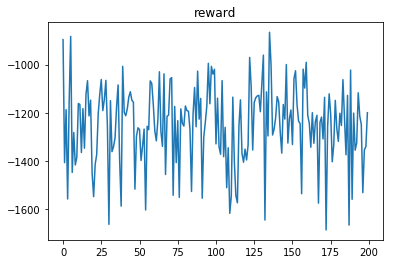

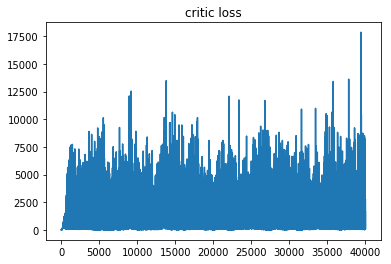

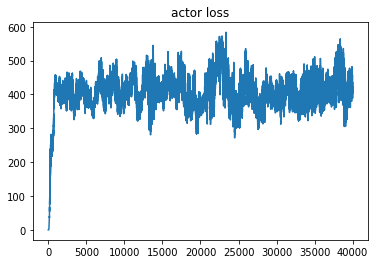

In [76]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.title('reward')
plt.show()

plt.plot(critic_loss_traj)
plt.title('critic loss')
plt.show()

plt.plot(actor_loss_traj)
plt.title('actor loss')
plt.show()

## Check result with rendering 


In [32]:
state = env.reset()

while True:
    
    env.render()

    state_input = torch.tensor(state, dtype=torch.float32)
    
    _, action_norm = agent.get_action(state_input)

    state, _, done, _ = env.step(action_norm)

    if done:
        break

env.close()

NotImplementedError: abstract